In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy import stats, special
import seaborn as sns 
sns.set_style("whitegrid")
from numpy.linalg import inv
# from pykalman import KalmanFilter

# Data Preparation

In [ ]:
# create dataframes from CSV's
cases = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kalman Filter Project/Cumulative_Cases.csv')
vac = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kalman Filter Project/Cumulative__Vaccinations.csv')
death = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kalman Filter Project/Cumulative__Deaths.csv')
hosp = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kalman Filter Project/Cumulative__Hospitalizations.csv')

In [ ]:
# combine into one dataframe
data = hosp.join(cases.set_index('Date'), on='Date').join(vac.set_index('Date'), on='Date').join(death.set_index('Date'), on='Date')

In [ ]:
data.head(15)

,Date,Hospitalizations,New Cases Reported,Cases,Vaccines,Deaths
0,2/25/2020,1092,0,1,NaN,2
1,2/26/2020,1094,0,1,NaN,4
2,2/27/2020,1105,0,1,NaN,4
3,2/28/2020,1114,0,1,NaN,6
4,2/29/2020,1121,0,1,NaN,7
5,3/1/2020,1129,0,1,NaN,10
6,3/2/2020,1150,13,14,NaN,13
7,3/3/2020,1162,16,30,NaN,16
8,3/4/2020,1176,15,45,NaN,18
9,3/5/2020,1203,21,66,NaN,23


In [ ]:
# create columns for daily counts, cases already has one
data['new_hosp'] = data['Hospitalizations'].diff()
data['new_vac'] = data['Vaccines'].diff()
data['new_deaths'] = data['Deaths'].diff()

In [ ]:
# add a time column
data['Time'] = np.arange(len(data.index))

In [ ]:
# check NA values do to nature of data can set NA values to 0
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 703 entries, 0 to 702
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                703 non-null    object 
 1   Hospitalizations    703 non-null    int64  
 2   New Cases Reported  703 non-null    int64  
 3   Cases               703 non-null    int64  
 4   Vaccines            407 non-null    float64
 5   Deaths              703 non-null    int64  
 6   new_hosp            702 non-null    float64
 7   new_vac             406 non-null    float64
 8   new_deaths          702 non-null    float64
 9   Time                703 non-null    int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 55.0+ KB


In [ ]:
data = data.fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 703 entries, 0 to 702
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                703 non-null    object 
 1   Hospitalizations    703 non-null    int64  
 2   New Cases Reported  703 non-null    int64  
 3   Cases               703 non-null    int64  
 4   Vaccines            703 non-null    float64
 5   Deaths              703 non-null    int64  
 6   new_hosp            703 non-null    float64
 7   new_vac             703 non-null    float64
 8   new_deaths          703 non-null    float64
 9   Time                703 non-null    int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 55.0+ KB


In [ ]:
data.head(15)

,Date,Hospitalizations,New Cases Reported,Cases,Vaccines,Deaths,new_hosp,new_vac,new_deaths,Time
0,2/25/2020,1092,0,1,0.0,2,0.0,0.0,0.0,0
1,2/26/2020,1094,0,1,0.0,4,2.0,0.0,2.0,1
2,2/27/2020,1105,0,1,0.0,4,11.0,0.0,0.0,2
3,2/28/2020,1114,0,1,0.0,6,9.0,0.0,2.0,3
4,2/29/2020,1121,0,1,0.0,7,7.0,0.0,1.0,4
5,3/1/2020,1129,0,1,0.0,10,8.0,0.0,3.0,5
6,3/2/2020,1150,13,14,0.0,13,21.0,0.0,3.0,6
7,3/3/2020,1162,16,30,0.0,16,12.0,0.0,3.0,7
8,3/4/2020,1176,15,45,0.0,18,14.0,0.0,2.0,8
9,3/5/2020,1203,21,66,0.0,23,27.0,0.0,5.0,9


# Data Exploration

In [ ]:
data.describe()

,Hospitalizations,New Cases Reported,Cases,Vaccines,Deaths,new_hosp,new_vac,new_deaths,Time
count,703.000000,703.000000,7.030000e+02,7.030000e+02,703.000000,703.000000,703.000000,703.000000,703.000000
mean,20034.984353,1841.389758,3.348000e+05,3.939406e+06,4523.671408,73.863442,17954.691323,15.216216,351.000000
std,14123.885448,3257.851156,2.900508e+05,4.450399e+06,3055.390423,57.055515,22558.748645,10.666075,203.082906
min,1092.000000,0.000000,1.000000e+00,0.000000e+00,2.000000,0.000000,0.000000,0.000000,0.000000
25%,7429.500000,470.500000,6.905400e+04,0.000000e+00,1809.500000,34.000000,0.000000,7.000000,175.500000
50%,19244.000000,912.000000,3.250510e+05,1.075985e+06,4807.000000,54.000000,9899.000000,12.000000,351.000000
75%,28215.500000,1981.000000,4.867350e+05,8.280368e+06,6250.500000,99.000000,30096.000000,21.000000,526.500000
max,53018.000000,39227.000000,1.294498e+06,1.262217e+07,10699.000000,339.000000,92611.000000,53.000000,702.000000


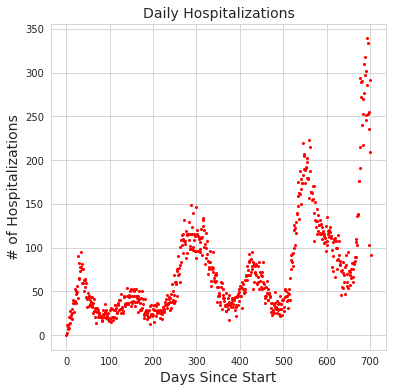

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(data['Time'], data['new_hosp'], color='red', s = 4)
plt.title('Daily Hospitalizations', fontsize=14)
plt.xlabel('Days Since Start', fontsize=14)
plt.ylabel('# of Hospitalizations', fontsize=14)
plt.grid(True)
plt.show()

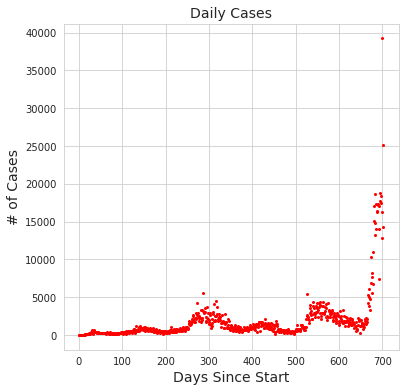

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(data['Time'], data['New Cases Reported'], color='red', s= 4)
plt.title('Daily Cases', fontsize=14)
plt.xlabel('Days Since Start', fontsize=14)
plt.ylabel('# of Cases', fontsize=14)
plt.grid(True)
plt.show()

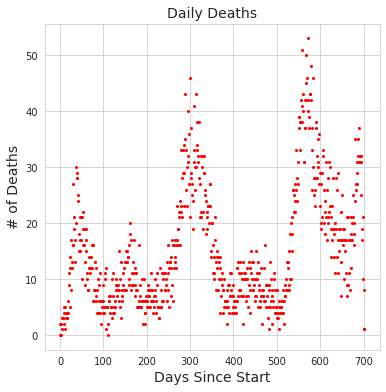

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(data['Time'], data['new_deaths'], color='red', s = 4)
plt.title('Daily Deaths', fontsize=14)
plt.xlabel('Days Since Start', fontsize=14)
plt.ylabel('# of Deaths', fontsize=14)
plt.grid(True)
plt.show()

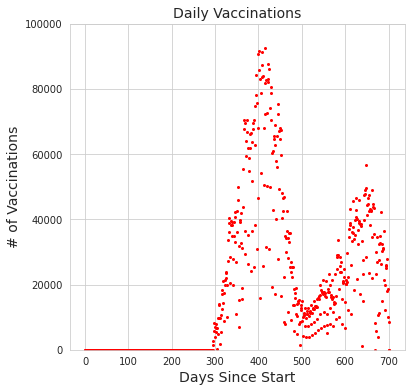

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(data['Time'], data['new_vac'], color='red', s = 4)
plt.title('Daily Vaccinations', fontsize=14)
plt.xlabel('Days Since Start', fontsize=14)
plt.ylabel('# of Vaccinations', fontsize=14)
plt.grid(True)
plt.ylim(0,100000)
plt.show()

# Multiple Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [ ]:
X = data[['New Cases Reported','new_deaths','new_vac','Time']]
Y = data[['new_hosp']]

x_train, x_test,y_train,y_test = train_test_split(X,Y,test_size =0.2)

In [ ]:
reg = linear_model.LinearRegression()
reg.fit(x_train,y_train)

print('Intercept: \n', reg.intercept_)
print('Coefficients: \n', reg.coef_)

Intercept: 
 [3.73040195]
Coefficients: 
 [[ 9.11634423e-03  2.25697559e+00 -8.56267415e-05  5.59569757e-02]]


In [ ]:
reg.score(x_train,y_train)

0.8252614450433253

In [ ]:
reg.score(x_test,y_test)

0.7538802492604677

In [ ]:
y_predicted = reg.predict(x_test)
resid = y_test - y_predicted

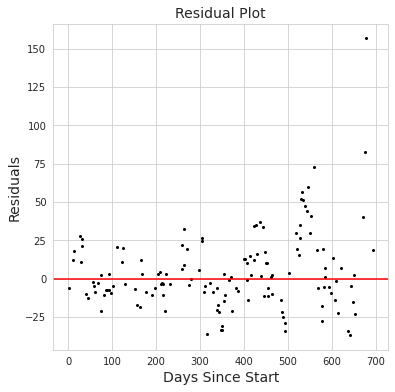

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(x_test['Time'], resid, color='black', s= 4)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot', fontsize=14)
plt.xlabel('Days Since Start', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.grid(True)
plt.show()

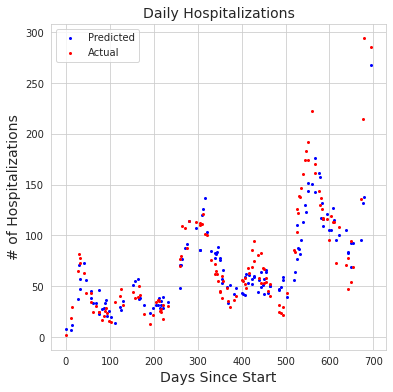

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(x_test['Time'], reg.predict(x_test), color='blue', s= 4)
plt.scatter(x_test['Time'], y_test['new_hosp'], color = 'red', s =4)
plt.legend(['Predicted','Actual'])
plt.title('Daily Hospitalizations', fontsize=14)
plt.xlabel('Days Since Start', fontsize=14)
plt.ylabel('# of Hospitalizations', fontsize=14)
plt.grid(True)
plt.show()